In [1]:
import time
from tqdm import tqdm
import scipy as sp
import numpy as np
import pandas as pd
import gc
from sklearn.linear_model import SGDClassifier
import re
import einops

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy, laplace
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
import sklearn as sk

import seaborn as sb
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
torch.manual_seed(42)

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)
#dtype = torch.float

# !pip install quadprog

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
from scipy import linalg

%matplotlib inline

Using TensorFlow backend.


cpu


In [2]:
# function for one hot encoding
def one_hot_encoding_func(array_data):
    b = np.zeros((array_data.size, array_data.max() + 1))
    b[np.arange(array_data.size), array_data] = 1
    return b

In [3]:
def reorder_axes_for_plotting(img):
    return img.transpose(0, 1).transpose(1, 2)

def computeZCAMAtrix(X):

    #This function computes the ZCA matrix for a set of observables X where
    #rows are the observations and columns are the variables (M x C x W x H matrix)
    #C is number of color channels and W x H is width and height of each image
    
    #normalize the data to [0 1] range
    temp_train_data=X/255
    
    #compute mean and std and normalize the data to -1 1 range with 1 std
    mean=(temp_train_data.mean(axis=(0)))
    std=(temp_train_data.std(axis=(0)))   
    temp_train_data=np.multiply(1/std,np.add(temp_train_data,-mean)) 
    
    
    #reshape data from M x C x W x H to M x N where N=C x W x H 
    temp_X = temp_train_data
    temp_X = temp_X.reshape(-1, 3072)
    
    # compute the covariance 
    cov = np.cov(temp_X, rowvar=False)   # cov is (N, N)
    
    # singular value decomposition
    U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,1) V is (N,N)
    # build the ZCA matrix which is (N,N)
    epsilon = 1e-5
    zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))

    return (torch.from_numpy(zca_matrix).float(), mean, std)  


class ZCATransformation(object):
    def __init__(self, transformation_matrix, transformation_mean):
        if transformation_matrix.size(0) != transformation_matrix.size(1):
            raise ValueError("transformation_matrix should be square. Got " +
                             "[{} x {}] rectangular matrix.".format(*transformation_matrix.size()))
        self.transformation_matrix = transformation_matrix
        self.transformation_mean = transformation_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (N, C, H, W) to be whitened.
        Returns:
            Tensor: Transformed image.
        """
        if tensor.size(1) * tensor.size(2) * tensor.size(3) != self.transformation_matrix.size(0):
            raise ValueError("tensor and transformation matrix have incompatible shape." +
                             "[{} x {} x {}] != ".format(*tensor[0].size()) +
                             "{}".format(self.transformation_matrix.size(0)))
        batch = tensor.size(0)

        flat_tensor = tensor.view(batch, -1)
        transformed_tensor = torch.mm(flat_tensor - self.transformation_mean, self.transformation_matrix)

        tensor = transformed_tensor.view(tensor.size())
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += (str(self.transformation_matrix.numpy().tolist()) + ')')
        return format_string
    
class CustomImageDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.img_labels = Y
        self.img = X

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        return self.img[idx], self.img_labels[idx]

In [4]:
# ZCA Whitening
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100

data_to_use = 'mnist'

if data_to_use =='mnist':
    from tensorflow.keras.datasets import mnist
    # load data
    dim_images = [28,28,1]
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

if data_to_use =='cifar':
    from tensorflow.keras.datasets import cifar10
    # load data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    dim_images = [32,32,3]

In [6]:


# reshape to be [samples][width][height][channels]
# X_train = X_train.transpose(0, 3, 1, 2)
# X_test = X_test.transpose(0, 3, 1, 2)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
# datagen = ImageDataGenerator(zca_whitening=False)
# datagen.fit(X_train)

# train_loader = torch.utils.data.DataLoader(datagen.flow(X_train, y_train, batch_size=batch_size), num_workers=num_workers,shuffle=True)
# test_loader = torch.utils.data.DataLoader(datagen.flow(X_test, y_test, batch_size=batch_size), num_workers=num_workers,shuffle=True)

# transformation_matrix, _mean, _std = computeZCAMAtrix(X_train)
# zca = ZCATransformation(transformation_matrix, _mean.reshape(-1))

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
dataset_ = 'MNIST'
# dataset_ = 'CIFAR10'

if dataset_ == 'MNIST':
    train_data = datasets.MNIST(root='data', train=True,
                                download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False,
                               download=True, transform=transform)
if dataset_ == 'CIFAR10':
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
    train_data = datasets.CIFAR10(root='data', train=True,
                                download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False,
                                 download=True, transform=transform)


# Create training and test dataloaders
# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)

# transformation_matrix, _mean, _std = computeZCAMAtrix(np.transpose(X_train, (0, 3, 1, 2)))
# zca = ZCATransformation(transformation_matrix, _mean.reshape(-1))

In [7]:
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = [str(i) for i in range(10)]

tensor(0.) tensor(0.1312) tensor(1.)


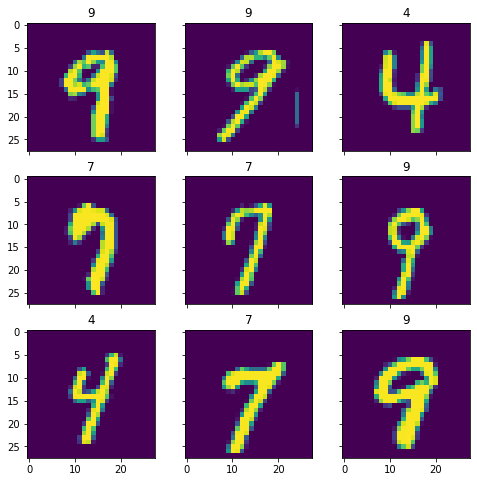

In [9]:
# configure batch size and retrieve one batch of images
for idx,data in enumerate(train_loader):

    # _ stands in for labels, here
    X_batch, y_batch = data
#     X_batch = zca(X_batch)
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    X_max = X_batch.max()
    X_min = X_batch.min()
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(np.transpose(((X_batch[i*3+j] - X_min )/(X_max - X_min)).numpy(), (1, 2, 0)))
            ax[i][j].set_title(classes[y_batch[i*3+j].reshape(-1).item()])
    # show the plot
    plt.show()
    break

In [10]:
# define the NN architecture
class NSM_Conv(nn.Module):
    def __init__(self,input_dim,encoding_dim,k_size,lrW=1e-3,beta1W=0.9,beta2W=0.999,lrM=1e-3,beta1M=0.9,beta2M=0.999):
        super(NSM_Conv, self).__init__()
        ## encoder ##
        self.encoder = nn.Conv2d(input_dim, \
                                 encoding_dim, \
                                 k_size, stride=1,\
                                 padding=0)
        torch.nn.init.normal_(self.encoder.weight, \
                              mean=0.0, \
                              std=1.0)        
        for iter_norm in range(encoding_dim):
                self.encoder.weight[iter_norm].data /= \
                torch.linalg.norm(self.encoder.weight[iter_norm].detach())
        ## decoder ##
        self.competitor = nn.Linear(encoding_dim, \
                                    encoding_dim, \
                                    bias=False)
        self.competitor.weight.data.copy_(torch.eye(encoding_dim))#/encoding_dim)
        
        self.optimizerW = torch.optim.Adam(self.encoder.parameters(), \
                                     lr=lrW, \
                                     betas=(beta1W, beta2W))
        self.optimizerM = torch.optim.Adam(self.competitor.parameters(), \
                                     lr=lrM, \
                                     betas=(beta1M, beta2M))

    def forward(self, x):
        num_iter = 40
        # initialize activities to zero
        Wx = self.encoder(x).detach()

        u = torch.zeros(Wx.size()).to(device)
        y = torch.zeros(Wx.size()).to(device)
        
        M = self.competitor.weight.detach() - torch.eye(self.competitor.weight.detach().size(0)).to(device)
        for iter_updates in range(num_iter):
            lr=1
            My = torch.einsum('ij,kjxy->kixy',M,y)
            delta_u = - u + Wx - My
            u += lr*delta_u
            y = F.relu(u)
        return y.detach()

    def pool_output(self, y,k_size,stri):
        m = nn.MaxPool2d(kernel_size=k_size, stride=stri)
        return m(y).detach()

    def loss_NSM_conv(self,y,x):
        
        scaling_factor = y.shape[0] * y.shape[2] * y.shape[3]
        Wx = self.encoder(x)
        YWX = (y*Wx).sum()/scaling_factor

        My = torch.einsum('ij,kjxy->kixy',\
                          self.competitor.weight,\
                          y)
        YMY = (y*My).sum()/scaling_factor
        
#         W_reg = (Wx**2).sum()/scaling_factor
        W_reg = (self.encoder.weight**2).sum()

        M_reg = (self.competitor.weight**2).sum()
        total_loss = -4* YWX + 2*YMY + 2*W_reg - M_reg

        return total_loss

    def train(self,y,x):

        self.optimizerW.zero_grad()
        loss = self.loss_NSM_conv(y,x)
        loss.backward()
        self.optimizerW.step()

        self.optimizerM.zero_grad()
        neg_loss = self.loss_NSM_conv(y,x) * (-1)
        neg_loss.backward()
        self.optimizerM.step()
        

In [17]:
# tau = np.array([1e4, 1e1])

running_loss = []
# for tau_ in tau:
# Train the model
model = NSM_Conv(1,50,6,lrW=1e-4,beta1W=0.99,beta2W=0.9999,lrM=1e-4,beta1M=0.99,beta2M=0.9999)
running_loss.append([])
for epoch in range(5):
    for idx,data in enumerate(train_loader):
        images, labels = data
#         images = zca(images)
        labels = torch.tensor(one_hot_encoding_func(labels.numpy()))

        outputs = model(images.to(device).type(torch.FloatTensor))
        model.train(outputs,images.to(device).type(torch.FloatTensor))

        pooled_outputs = model.pool_output(outputs,k_size = 2, stri = 2)
        loss = model.loss_NSM_conv(outputs, images)
        running_loss[-1].append(loss.item())
        if idx % 10 == 9:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, idx + 1, running_loss[-1][-1] / batch_size), end = '\r')



In [19]:
train_labels_data = []
train_embedded_data = []

###########################################
# Extract train set values after training #
###########################################
for idx,data in enumerate(tqdm(train_loader)):

    images, lbl = data

    outputs = model(images.to(device).type(torch.FloatTensor))
    pooled_outputs = model.pool_output(outputs,k_size = 2, stri = 2)

    if train_embedded_data==[]:
        train_embedded_data = pooled_outputs.detach().cpu()
        train_labels_data = lbl
    else:
        train_embedded_data = torch.cat((train_embedded_data,pooled_outputs.detach().cpu()),0)
        train_labels_data =torch.cat((train_labels_data,lbl),0)

test_labels_data = []
test_embedded_data = []

##########################################
# Extract test set values after training #
##########################################
for idx,data in enumerate(tqdm(test_loader)):

    images, lbl = data

    outputs = model(images.to(device).type(torch.FloatTensor))
    pooled_outputs = model.pool_output(outputs,k_size = 2, stri = 2)

    if test_embedded_data==[]:
        test_embedded_data = pooled_outputs.detach().cpu()
        test_labels_data = lbl
    else:
        test_embedded_data = torch.cat((test_embedded_data,pooled_outputs.detach().cpu()),0)
        test_labels_data =torch.cat((test_labels_data,lbl),0)

classifier = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
        

100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


In [20]:
resh_train_embedded_data = train_embedded_data.reshape(-1,train_embedded_data.shape[1]*train_embedded_data.shape[2]*train_embedded_data.shape[3])
indices = np.random.randint(train_embedded_data.shape[0], size = int(train_embedded_data.shape[0]))
data = resh_train_embedded_data.numpy()[indices, :]
target = train_labels_data[indices]

classifier.fit(data, target)

train_error = classifier.score(data, target)

resh_test_embedded_data = test_embedded_data.reshape(-1,test_embedded_data.shape[1]*test_embedded_data.shape[2]*test_embedded_data.shape[3])
data_test = resh_test_embedded_data.numpy()
target_test = test_labels_data.numpy()
score = classifier.score(data_test, target_test)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * score))

Accuracy of the network on the 10000 test images: 97 %


In [8]:
# define the NN architecture
class Supervised_NSM_Conv(nn.Module):
    def __init__(self,input_dim,encoding_dim,k_size,num_labels,etaW=1e-3,etaM=1e-3,tau=1e-1,tauLabel=1e0,dropout_p=None,x_whitening=False):
        super(Supervised_NSM_Conv, self).__init__()
        ## encoder ##
        self.in_channels = input_dim
        self.encoding_dim = encoding_dim
        self.encoder = nn.Conv2d(input_dim, encoding_dim, k_size, stride=1,padding=0)
        torch.nn.init.normal_(self.encoder.weight, mean=0.0, std=1.0)        
        for iter_norm in range(encoding_dim):
                self.encoder.weight[iter_norm].data /= torch.linalg.norm(self.encoder.weight[iter_norm].detach())

        ## competitor ##
        self.competitor = nn.Linear(encoding_dim, encoding_dim,bias=False)
        self.competitor.weight.data.copy_(torch.eye(encoding_dim))#/encoding_dim)
        self.dropout_p = dropout_p

        ## dropout and input whitening ##
        if dropout_p is not None:
            self.dropout = nn.Dropout(p=self.dropout_p)          
        self.x_whitening = x_whitening

        ## learning rates
        self.etaW = etaW
        self.etaM = etaM
        self.tau = tau
        self.tauLabel = tauLabel
        
        # Decay/schedule
        self.t_step = 0
        self.decay = 1e-1


        # Weights for the labels
        self.num_labels = num_labels

        self.encoder_labels = nn.Conv2d(num_labels, encoding_dim, k_size, stride=1,padding=0)
        torch.nn.init.normal_(self.encoder_labels.weight, mean=0.0, std=1.0)        
        for iter_norm in range(encoding_dim):
                self.encoder_labels.weight[iter_norm].data /= torch.linalg.norm(self.encoder_labels.weight[iter_norm].detach())

        #self.competitor_labels = nn.Linear(encoding_dim, encoding_dim,bias=False)
        #self.competitor_labels.weight.data.copy_(torch.eye(encoding_dim))#/encoding_dim)


    def forward(self, x, label=None):

        num_iter = 40
        Wx = self.encoder(x).detach()
        if label is not None:
            Wlabel = self.encoder_labels(label).detach()
        
        #if self.dropout_p is not None:
        #  Wx = (1/self.dropout_p)*self.dropout(Wx)

        M = self.competitor.weight.detach() - torch.eye(self.competitor.weight.detach().size(0)).to(device)

        u = torch.zeros(Wx.size()).to(device)
        y = torch.zeros(Wx.size()).to(device)
        
        if label is not None:
            for iter_updates in range(num_iter):
                My = torch.einsum('ij,kjxy->kixy',M,y)
                #delta_u = - u + Wx - My
                u = Wx + Wlabel - My
                y = F.relu(u)
        else:
            for iter_updates in range(num_iter):
                My = torch.einsum('ij,kjxy->kixy',M,y)
                #delta_u = - u + Wx - My
                u = Wx - My
                y = F.relu(u)
        
        #if self.dropout is not None:
        #  y = self.dropout(y)

        return y.detach()

    def pool_output(self, y,k_size,stri):
        m = nn.MaxPool2d(kernel_size=k_size, stride=stri)
        return m(y).detach()


    def pool_quadrant(self, y):
        Width_Im = y.shape[2]

        if Width_Im%2 ==0:
            kernel_size = Width_Im//2
            stride = kernel_size
        else:
            kernel_size = math.ceil(Width_Im / 2)
            stride = kernel_size - 1
        
        m = nn.MaxPool2d(kernel_size=kernel_size, stride=stride)
        return m(y).detach()


    def loss_NSM_conv(self,y,x,label,print_ = False):
        
        scaling_factor = y.shape[0]*y.shape[2]*y.shape[3]

        Wx = self.encoder(x)
        Wlabel = self.encoder_labels(label)


        YWX = (y*Wx).sum()/scaling_factor 

        My = torch.einsum('ij,kjxy->kixy',self.competitor.weight,y)
        YMY = (y*My).sum()/scaling_factor 

        if self.x_whitening ==True:
            W_reg = (Wx**2).sum()/scaling_factor
        else:
            W_reg = (self.encoder.weight**2).sum()

        # supervised part
        YWlabel = (y*Wlabel).sum()/scaling_factor 
        Wlabel_reg = (Wlabel**2).sum()/scaling_factor


        M_reg = (self.competitor.weight**2).sum()
        total_loss = (-4* YWX + 2*YMY + 2*W_reg - M_reg) -4*YWlabel  + 2*Wlabel_reg
        if print_ == True:
            print(W_reg.detach().cpu(),M_reg.detach().cpu(),YWX.detach().cpu(),YMY.detach().cpu())
        return total_loss

    def train(self,y,x,label,etaW=None,etaM=None,tau=None, tauLabel=None):
        if etaW is None:
            etaW = self.etaW
        if etaM is None:
            etaM = self.etaM
        if tau is None:
            tau = self.tau
        if tauLabel is None:
            tauLabel = self.tauLabel

        self.loss_NSM_conv(y,x,label).backward()

        # gradients
        gW  =  self.encoder.weight.grad.data
        gM  =  self.competitor.weight.grad.data
        gWlabel  =  self.encoder_labels.weight.grad.data

        # updates
        lr_schedule = 1 #1 / ( 1 + self.t_step * self.decay )

        with torch.no_grad():
            self.encoder.weight -= etaW* lr_schedule * gW
            self.competitor.weight += (etaM/tau)*lr_schedule * gM
            self.encoder_labels.weight -= (etaW/tauLabel)* lr_schedule * gWlabel

        self.encoder.weight.grad.zero_()
        self.competitor.weight.grad.zero_()
        self.encoder_labels.weight.grad.zero_()

        self.t_step += 10 
        

    def plot_features(self):
        # function to plot features
        
        if self.in_channels==1:
            plt.figure(figsize=(10,10))
            for iter_filter in range(min(25,self.encoding_dim)):
                plt.subplot(5, 5, iter_filter+1)
                plt.imshow(self.encoder.weight[iter_filter].reshape(self.in_channels,k_size,k_size).detach().cpu())
            plt.colorbar()
            plt.show()

        else:
            for iter_chan in range(1):
                plt.figure(figsize=(10,10))
                for iter_filter in range(min(50,self.encoding_dim)):
                    plt.subplot(5, 10, iter_filter+1)
                    plt.imshow(self.encoder.weight[iter_filter,iter_chan,:,:].squeeze().detach().cpu())
                plt.colorbar()
                plt.show()


In [40]:
# tau = np.array([1e4, 1e1])
num_labels = 10
alpha_ = np.logspace(2,-2,5)
running_loss = []
alpha = 1e0
tau = 1e-1
tauLabel = 1e0
# for tau_ in tau:
# Train the model
# for tauLabel in alpha_:
filter_video = []
model = Supervised_NSM_Conv(1,50,6,num_labels,etaW=1e-3,etaM=1e-3,tau=tau,tauLabel=tauLabel)
weight_filters = model.encoder.weight
for epoch in range(2):
    for idx,data in enumerate(train_loader):
        images, labels = data
#         labels = torch.tensor(one_hot_encoding_func(labels.numpy()))

        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_labels)
        repeat_labels = einops.repeat(alpha*one_hot_labels, 'm n -> m n k l', k=images.shape[2],l=images.shape[3]).float()

        # forward pass
        outputs = model(images.to(device),10*repeat_labels.to(device))
        # loss estimation
        loss = model.loss_NSM_conv(outputs,images.to(device),repeat_labels.to(device),print_ = False)
        # backward pass
        model.train(outputs,images.to(device),repeat_labels.to(device))
        torch.cuda.empty_cache()

        running_loss.append(loss.item())
        if idx % 10 == 9:
            filter_video.append(np.copy(np.transpose(model.encoder.weight.detach().numpy()[0, :], (1, 2, 0))))
            print('[%.1e, %5d] loss: %.3f' % (tauLabel, idx + 1, running_loss[-1] / batch_size), end = '\r')


In [36]:
train_labels_data = []
train_embedded_data = []

###########################################
# Extract train set values after training #
###########################################
for idx,data in enumerate(tqdm(train_loader)):

    images, labels = data

    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_labels)
    repeat_labels = einops.repeat(0*one_hot_labels, 'm n -> m n k l', k=images.shape[2],l=images.shape[3]).float()

    # forward pass
    outputs = model(images.to(device),10*repeat_labels.to(device))
    pooled_outputs = model.pool_output(outputs,k_size = 2, stri = 2)

    if train_embedded_data==[]:
        train_embedded_data = pooled_outputs.detach().cpu()
        train_labels_data = labels
    else:
        train_embedded_data = torch.cat((train_embedded_data,pooled_outputs.detach().cpu()),0)
        train_labels_data =torch.cat((train_labels_data,labels),0)

test_labels_data = []
test_embedded_data = []

##########################################
# Extract test set values after training #
##########################################
for idx,data in enumerate(tqdm(test_loader)):

    images, labels = data

    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_labels)
    repeat_labels = einops.repeat(0*one_hot_labels, 'm n -> m n k l', k=images.shape[2],l=images.shape[3]).float()

    # forward pass
    outputs = model(images.to(device),10*repeat_labels.to(device))
    pooled_outputs = model.pool_output(outputs,k_size = 2, stri = 2)

    if test_embedded_data==[]:
        test_embedded_data = pooled_outputs.detach().cpu()
        test_labels_data = labels
    else:
        test_embedded_data = torch.cat((test_embedded_data,pooled_outputs.detach().cpu()),0)
        test_labels_data =torch.cat((test_labels_data,labels),0)

classifier = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
        

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [37]:
resh_train_embedded_data = train_embedded_data.reshape(-1,train_embedded_data.shape[1]*train_embedded_data.shape[2]*train_embedded_data.shape[3])
indices = np.random.randint(train_embedded_data.shape[0], size = int(train_embedded_data.shape[0]))
data = resh_train_embedded_data.numpy()[indices, :]
target = train_labels_data[indices]

classifier.fit(data, target)

train_error = classifier.score(data, target)

resh_test_embedded_data = test_embedded_data.reshape(-1,test_embedded_data.shape[1]*test_embedded_data.shape[2]*test_embedded_data.shape[3])
data_test = resh_test_embedded_data.numpy()
target_test = test_labels_data.numpy()
score = classifier.score(data_test, target_test)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * score))

Accuracy of the network on the 10000 test images: 98 %


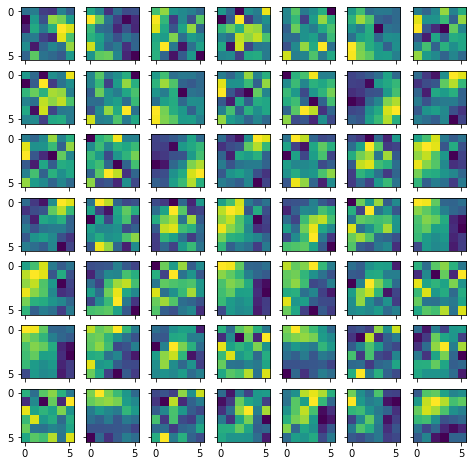

In [25]:
filters = model.encoder.weight.detach().numpy()
filters_min = np.amin(filters)
filters_max = np.amax(filters)

fig, ax = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(8,8))
for i in range(7):
    for j in range(7):
        ax[i][j].imshow((filters[i*3+j, 0] - filters_min )/(filters_max - filters_min))
# show the plot
plt.show()

In [ ]:
alpha = 1e0
tau = 1e-1
tauLabel = 1e0
Accuracy = 23%

alpha = 1e-1
tau = 1e0
tauLabel = 1e1
Accuracy = 34%

alpha = 1e-1
tau = 1e-1
tauLabel = 1e0
Accuracy = 33%

alpha = 0
tau = 1e-1
tauLabel = 1e0
Accuracy = 34%
